In [1]:
# import SAGA code

import SAGA
from SAGA import ObjectCuts as C
from SAGA.utils import get_sdss_bands, get_sdss_colors

print('SAGA code version', SAGA.__version__)

SAGA code version 0.2.6


In [2]:
# import other modules

import numpy as np
from easyquery import Query
from scipy.optimize import minimize
from sklearn.decomposition import PCA

In [4]:
# import more modules

from IPython.display import display
import matplotlib.pyplot
plt = matplotlib.pyplot
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = 6.0, 4.0

In [4]:
# initialize SAGA objects (Database, HostCatalog, ObjectCatalog)
# NOTE: change the path of `root_dir` to your SAGA dropbox path

saga_database = SAGA.Database(root_dir='/home/yymao/Dropbox/Academia/Collaborations/SAGA')
saga_object_catalog = SAGA.ObjectCatalog(saga_database)

## define our simple model

In [5]:
class SimpleModel(object):
    def __init__(self):
        self._parameters = dict()
    
    def set_pca_axis(self, component1, component2):
        self._parameters['pca_gr'] = component1
        self._parameters['pca_ri'] = component2
        self._parameters['gri_cut'] = self.calc_pca_score(0.85, 0.55)
        
    def calc_pca_score(self, gr, ri):
        return gr*self._parameters['pca_gr'] + ri*self._parameters['pca_ri']
    
    def calc_satellite_prob(self, pca_score, parameters=None):
        if parameters is None:
            x0, w, a = self._parameters['p_sat_x0'], self._parameters['p_sat_w'], self._parameters['p_sat_a']
        else:
            x0, w, a = parameters
        return np.where(pca_score > self._parameters['gri_cut'], np.minimum(np.exp((pca_score-x0)*w), a), 0.0)
    
    def calc_neg_log_likelihood(self, parameters, pca_score_sat, pca_score_nonsat):
        return -(np.sum(np.log(self.calc_satellite_prob(pca_score_sat, parameters))) + \
                np.sum(np.log(1.0-self.calc_satellite_prob(pca_score_nonsat, parameters))))
    
    def set_p_sat_parameters(self, parameters):
        self._parameters['p_sat_x0'], self._parameters['p_sat_w'], self._parameters['p_sat_a'] = parameters
        
    def get_parameter_tuple(self):
        return (self._parameters.get('pca_gr'), self._parameters.get('pca_ri'), self._parameters.get('gri_cut'), 
               self._parameters.get('p_sat_x0'), self._parameters.get('p_sat_w'), self._parameters.get('p_sat_a'))
        
        
model = SimpleModel()

## find PCA axis

In [6]:
# load all specs
# specify columns to load
columns = 'OBJID HOST_NSAID SATS SPEC_Z ZQUALITY'.split()
columns.extend(map('{}_mag'.format, get_sdss_bands()))
columns.extend(map('{}_err'.format, get_sdss_bands()))
columns.extend(get_sdss_colors())
columns.extend(map('{}_err'.format, get_sdss_colors()))

# specify cuts to apply
cuts = C.basic_cut & (~C.sdss_limit) & Query('gr > -100.0', 'gr < 100.0', 'ri > -100.0', 'ri < 100.0')

# load base catalogs (will take a while)
specs = saga_object_catalog.load(has_spec=True, cuts=cuts, columns=columns, return_as='stacked')

In [7]:
# get PCA axis
pca = PCA(1, random_state=12345)
pca.fit(np.asarray(specs[['gr', 'ri']]).view((np.float32, 2)))
model.set_pca_axis(*pca.components_[0])

In [8]:
# calculate scores
pca_score = model.calc_pca_score(np.asarray(specs['gr']), np.asarray(specs['ri']))
pca_score_sat = pca_score[C.is_sat.mask(specs)]
pca_score_nonsat = pca_score[(~C.is_sat).mask(specs)]

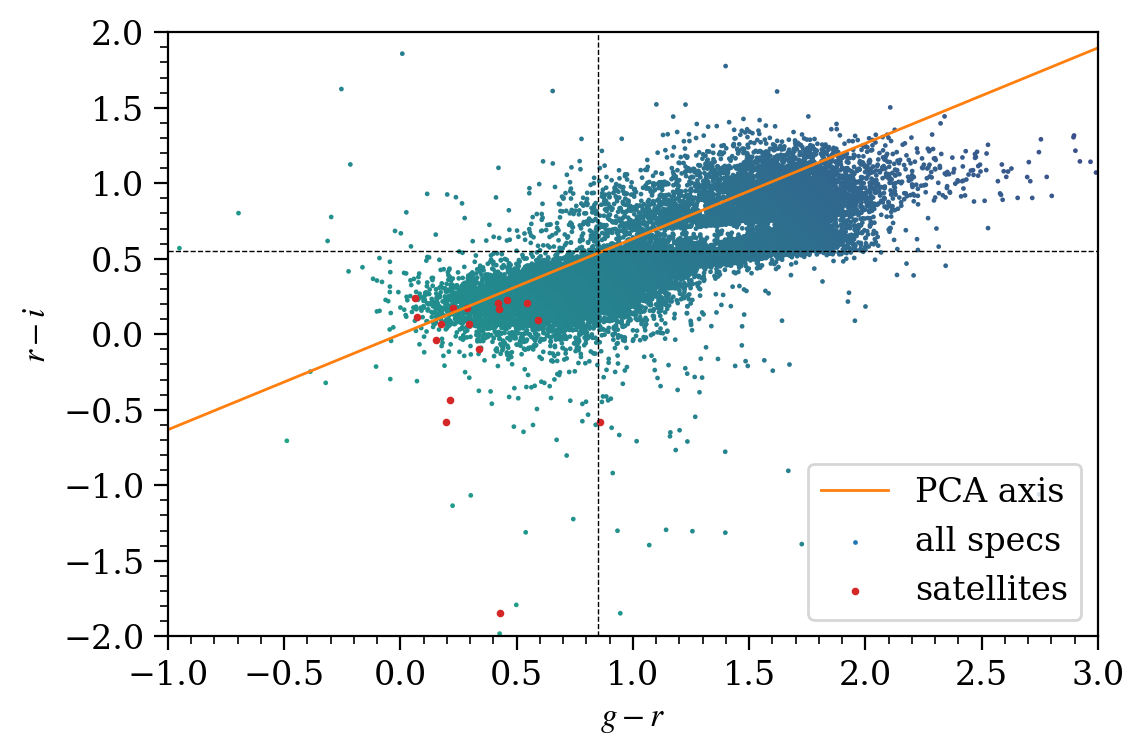

In [9]:
plt.scatter(specs['gr'], specs['ri'], s=0.5, c=pca_score, rasterized=True, label='all specs');
plt.scatter(C.is_sat.filter(specs)['gr'], C.is_sat.filter(specs)['ri'], s=3, c='C3', label='satellites');
xlim = np.array([-1, 3])
plt.plot(xlim, xlim/np.true_divide(*model.get_parameter_tuple()[:2]), c='C1', lw=1, label='PCA axis')
plt.xlim(*xlim);
plt.ylim(-2, 2);
plt.axhline(0.55, c='k', ls='--', lw=0.5);
plt.axvline(0.85, c='k', ls='--', lw=0.5);
plt.xlabel('$g-r$');
plt.ylabel('$r-i$');
plt.legend(loc='lower right', frameon=True);

## fit our simple model

In [17]:
# do a random search first to get a starting point
para = np.random.rand(30000, 3)*np.array([0.5, 8.0, 0.07]) + np.array([0, 6.0, 0.03])
para_best = para[np.argmin(np.fromiter((model.calc_neg_log_likelihood(_, pca_score_sat, pca_score_nonsat) for _ in para), np.float, len(para)))]
print(para_best, model.calc_neg_log_likelihood(para_best, pca_score_sat, pca_score_nonsat))

[ 0.18366778  9.47126681  0.05933228] 94.188


In [18]:
# actually do the fitting
fit = minimize(model.calc_neg_log_likelihood, para_best, (pca_score_sat, pca_score_nonsat), method='Nelder-Mead')
display(fit)
model.set_p_sat_parameters(fit.x)

 final_simplex: (array([[ 0.18598332,  9.41026987,  0.0559141 ],
       [ 0.18598559,  9.41021955,  0.05591382],
       [ 0.1859853 ,  9.41022464,  0.0559139 ],
       [ 0.18598344,  9.41026235,  0.0559142 ]]), array([ 94.17974854,  94.17974854,  94.17975616,  94.17976379]))
           fun: 94.17974853515625
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 60
        status: 0
       success: True
             x: array([ 0.18598332,  9.41026987,  0.0559141 ])

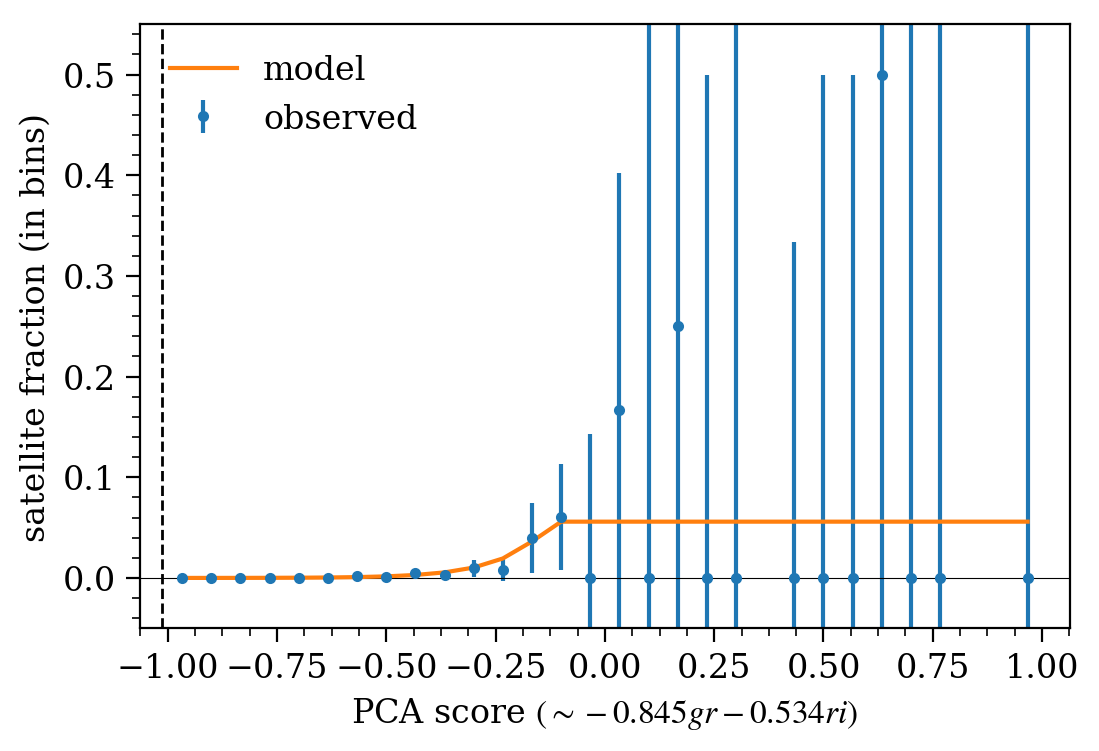

In [79]:
# see how well we do
bins = np.linspace(-1, 1, 31)
bin_c = 0.5*(bins[1:]+bins[:-1])

ha = np.histogram(pca_score, bins)[0]
hs = np.histogram(pca_score_sat, bins)[0]

plt.axhline(0, c='k', lw=0.4)
plt.errorbar(bin_c[ha>0], hs[ha>0]/ha[ha>0], np.sqrt(hs[ha>0]+1)/ha[ha>0], marker='.', ls='', label='observed');
plt.plot(bin_c, model.calc_satellite_prob(bin_c), label='model')
plt.ylim(-0.05, 0.55);
plt.legend(loc='upper left')

plt.axvline(model.get_parameter_tuple()[2], c='k', ls='--', lw=1);
plt.ylabel('satellite fraction (in bins)');
plt.xlabel('PCA score $(\\sim {0:.3f}gr{1:.3f}ri)$'.format(*model.get_parameter_tuple()));

## some more sanity checks

In [20]:
# Is there a PCA score beyond which there are only satellites?
print(np.count_nonzero(pca_score_sat >= pca_score_nonsat.max()))

0


In [21]:
# How many satellites observed? And how many does our simple model predict?
print(C.is_sat.count(specs), model.calc_satellite_prob(pca_score).sum())

17 16.994


In [22]:
# Beyond the point where the satellite probability saturates, what's the fraction of satellites (observed and predicted)?
x = np.linspace(-1, 1, 1001)
x = x[model.calc_satellite_prob(x).argmax()]
print(np.count_nonzero(pca_score_sat > x)/np.count_nonzero(pca_score > x), model.get_parameter_tuple()[-1])

0.05555555555555555 0.0559140969154


## Compare with GMM probablitly

In [36]:
from SAGA.targets import calc_gmm_satellite_probability, calc_simple_satellite_probability

In [37]:
gmm_score = calc_gmm_satellite_probability(C.gri_cut.filter(specs), saga_database['gmm_parameters'].read())
pca_score_gri = model.calc_satellite_prob(pca_score[C.gri_cut.mask(specs)])

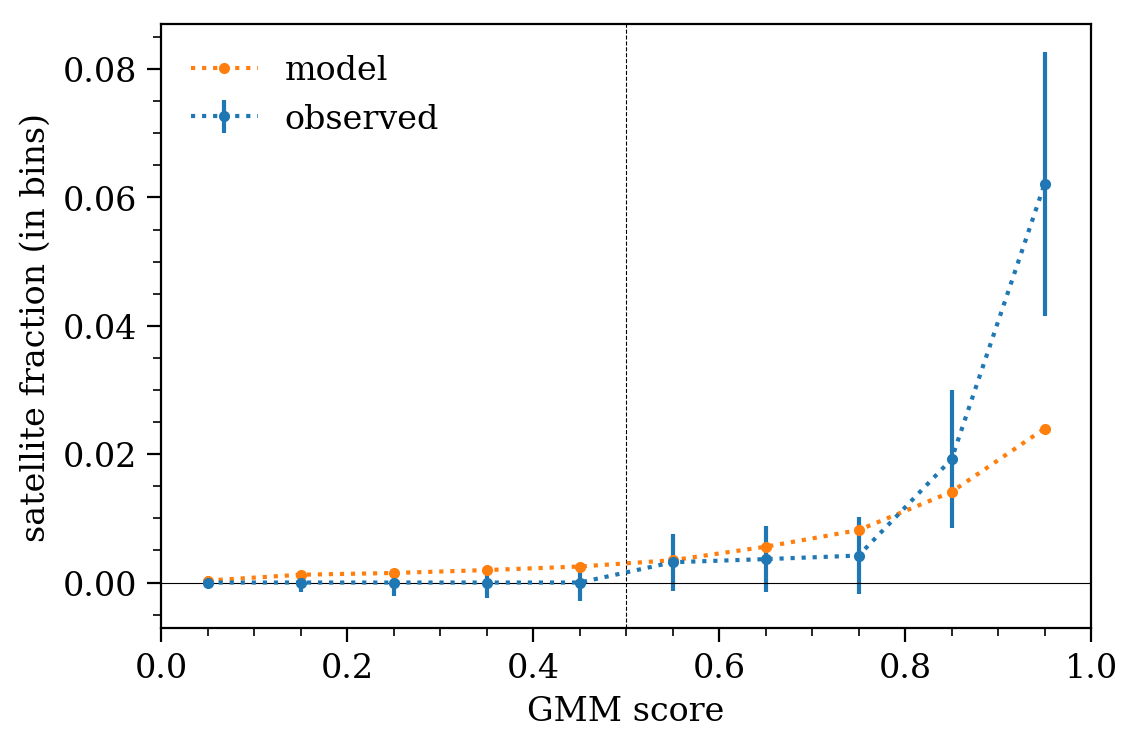

In [81]:
# see how well we do
bins = np.linspace(0, 1, 11)
bin_c = 0.5*(bins[1:]+bins[:-1])

d = np.digitize(gmm_score, bins, True)
d -= 1

ha = np.histogram(gmm_score, bins)[0]
hs = np.histogram(gmm_score[C.is_sat.mask(C.gri_cut.filter(specs))], bins)[0]

plt.axhline(0, c='k', lw=0.4)
plt.axvline(0.5, c='k', lw=0.4, ls='--')
plt.errorbar(bin_c, hs/ha, np.sqrt(hs+1)/ha, marker='.', ls=':', label='observed');
plt.plot(bin_c, np.array([pca_score_gri[d==i].mean() for i in range(len(bins)-1)]), '.:', label='model')
plt.xlim(0, 1);
plt.legend(loc='upper left')

plt.ylabel('satellite fraction (in bins)');
plt.xlabel('GMM score'.format(*model.get_parameter_tuple()));

## finally, print out our model parameters

In [23]:
print(model.get_parameter_tuple())

(-0.84526783, -0.53434289, -1.0123662441968917, 0.18598332213910629, 9.4102698701884755, 0.055914096915391752)
